# HITS

### Step 1. Review HITS algorithm

In this step, we will briefly review HITS algorithm which is another global node ranking model in graphs. 

#### Step 1-1. Mathematical definition of HITS
Given an adjacency matrix of a graph, HITS computes the hub and authority score vectors which can be used for ranking nodes in the graph. 

##### HITS' Problem definition
* **Input**: adjacency matrix $\mathbf{A}\in \mathbb{R}^{n \times n}$ of a graph $G=(V, E)$
* **Output**: hub score vector $\mathbf{h} \in \mathbb{R}^{n}$, and authority score vector $\mathbf{a} \in \mathbb{R}^{n}$ such that

    - $\mathbf{h} = \mathbf{A}\mathbf{a}$
    - $\mathbf{a} = \mathbf{A}^{\top}\mathbf{h}$

#### Step 1-2. Iterative Algorithm for HITS
The hub and authority score vectors, $\mathbf{h}$ and $\mathbf{a}$, are obtained by iteratively computing the equations for HITS.   
Note that for each iteration, we need to L2-normalize the vectors $\mathbf{h}$ and $\mathbf{a}$.
The following pseudo-code represents the iterative algorithm for HITS. 

<img src="./images/iterative-algorithm-hits.png" width="400">

We will implement the iterative algorithm in Python. 

------

### Step 2. Implement HITS algorithm - The sparse matrix version
We are going to implement the sparse matrix (= a matrix in which most of the elements are zero) version of HITS algorithm in Python.

#### Step 2-2. Implement the phase for loading the graph dataset
In this step, we will implement the phase for loading the graph dataset of the sparse matrix version of HITS. 
We first need to import the following packages for this. 

In [222]:
import numpy as np
# SciPy 2-D sparse array package for numeric data
from scipy.sparse import csr_matrix, find # csr_matrix is for Compressed Sparse Row matrixes
                                          # find returns the indices and values of the nonzero elements of a matrix
import pandas as pd

We implement the following function for load graph datasets.
We briefly introduce several APIs in `numpy` used when implementing the below function which constructs the adjacency matrix of a graph.
* `loadtxt`: this loads data from a text file
* `amax`: this returns the maximum of an array
* `shape`: this returns the dimension of an array (or matrix)
    - `A.shape` will return `(m, n)` where m is # of rows, and n is # of columns
* `count_nonzero`: this returns the number of non-zeros of a matrix
* slice: `edges[:, 0:2]` will return the first and second columns of `edges` matrix.

In [223]:
# HITS using sparse matrixes
class SparseHITS:
    # I load the graph dataset from the directory "data_home" (a string). The dataset is made up of nodes + edges (edges.tsv, node_labels.tsv)
    # is_underected specify if the graph is underected or not
    def load_graph_dataset(self, data_home, is_undirected=False):
        # STEP 1. self file paths from data_home
        edge_path = "{}/edges.tsv".format(data_home) # tsv is for tab-separated values
                                                     # .format formats the specified values and insert them inside the string's placeholder {}
        
        # STEP 2. Read the list of edges from edge_path
        edges = np.loadtxt(edge_path, dtype=int)
        n = int(np.amax(edges[:, 0:2])) + 1
        
        # STEP 3. convert the edge list to the weighted adjacency matrix
        rows = edges[:, 0]
        cols = edges[:, 1]
        weights = edges[:, 2]
        self.A = csr_matrix((weights, (rows, cols)), shape=(n, n), dtype=float)
        if is_undirected:
            self.A = self.A + self.A.T
        self.AT = self.A.T
                
        # STEP 4. set n (# of nodes) and m (# of edges)
        self.n = self.A.shape[0]     # number of nodes
        # .nnz get the count of explicitly-stored values (nonzeros)
        self.m = self.A.nnz          # number of edges

In [224]:
class SparseHITS(SparseHITS):
    def load_node_labels(self, data_home):
        # Load the node labels from the given directory data_home
        label_path = "{}/node_labels.tsv".format(data_home)
        self.node_labels = pd.read_csv(label_path, sep="\t")        

Let's check if the function is correctly implemented, by using the small dataset at `./data/small`.

In [225]:
hits = SparseHITS()
hits.load_graph_dataset('./data/small', is_undirected=False)
print("The number n of nodes: {}".format(hits.n))
print("The number m of edges: {}".format(hits.m))

The number n of nodes: 29
The number m of edges: 376


In [226]:
class SparseHITS(SparseHITS):
    # Iterate the HITS equation to obatin the hub & authority score vectors
    def iterate_HITS(self, epsilon= 1e-9, max_iters= 100): # epsilon is a float for the error tolerance of the iteration
                                                           # 1e-9 is 0.000000001 
        old_h = np.ones(self.n)/self.n
        old_a = np.ones(self.n)/self.n
        h_residuals = []
        a_residuals = []
        
        for t in range(max_iters):
            h = self.A.dot(old_a) # dot product of two arrays
            a = self.AT.dot(h)
                        
            h = h / np.linalg.norm(h, 2) # linalg is for linear algebra, norm(..., n) returns the nth norm
            a = a / np.linalg.norm(a, 2)
            
            h_residual = np.linalg.norm(h - old_h, 1)
            a_residual = np.linalg.norm(a - old_a, 1)
            h_residuals.append(h_residual)
            a_residuals.append(a_residual)
            old_h = h
            old_a = a
            
            if h_residual < epsilon and a_residual < epsilon:
                break
        # h is a np.ndarray (n x 1 vector) for the final hub score vector
        # a is np.ndarray (n x 1 vector) for the final authority score vector
        # h_residuals is the list of hub residuals over the iteration
        # a_residuals is the list of authority residuals over the iteration
        return h, a, h_residuals, a_residuals, t

Let's check the implementation is correctly performed by checking each personalized ranking result with `pandas`. 

See the following code where a seed node is given. Note that the given seed node should have a high ranking score. 

In [227]:
import pandas as pd

def rank_nodes(ranking_scores, topk=-1):
    sorted_nodes = np.flipud(np.argsort(ranking_scores))
    ranking_results = pd.DataFrame()
    ranking_results["node_id"] = sorted_nodes
    
    return ranking_results[0:topk]

In [228]:
from IPython.display import display

hits = SparseHITS()
hits.load_graph_dataset('./data/small', is_undirected=False)
h, a, _, _, n_iterations = hits.iterate_HITS(epsilon=1e-9, max_iters=100)

print("{} iterations were necessary.".format(n_iterations))

rank_hubs = rank_nodes(h, 10)
rank_aut = rank_nodes(a, 10)

print("Top-10 rankings based on the hub score vector:")
display(rank_hubs)

print("Top-10 rankings based on the authority score vector:")
display(rank_aut)

11 iterations were necessary.
Top-10 rankings based on the hub score vector:


,node_id
0,4
1,5
2,3
3,2
4,21
5,8
6,25
7,26
8,20
9,7


Top-10 rankings based on the authority score vector:


,node_id
0,7
1,8
2,10
3,13
4,11
5,22
6,19
7,20
8,12
9,14


### Network x
I check if the results are the same when applying the hits function from Network X. I used a csv file now, just to try with both formats.

In [229]:
# Read the file of the edges
import csv
with open('edges_small.csv') as f:
    data=[tuple(line) for line in csv.reader(f)]

In [230]:
# Create a list of tuples (considering the weights too)
def create_w_edges(data):
    my_edges = [(int(i[0]), int(i[1]), int(i[2])) for i in data]
    return my_edges

w_edges = create_w_edges(data)

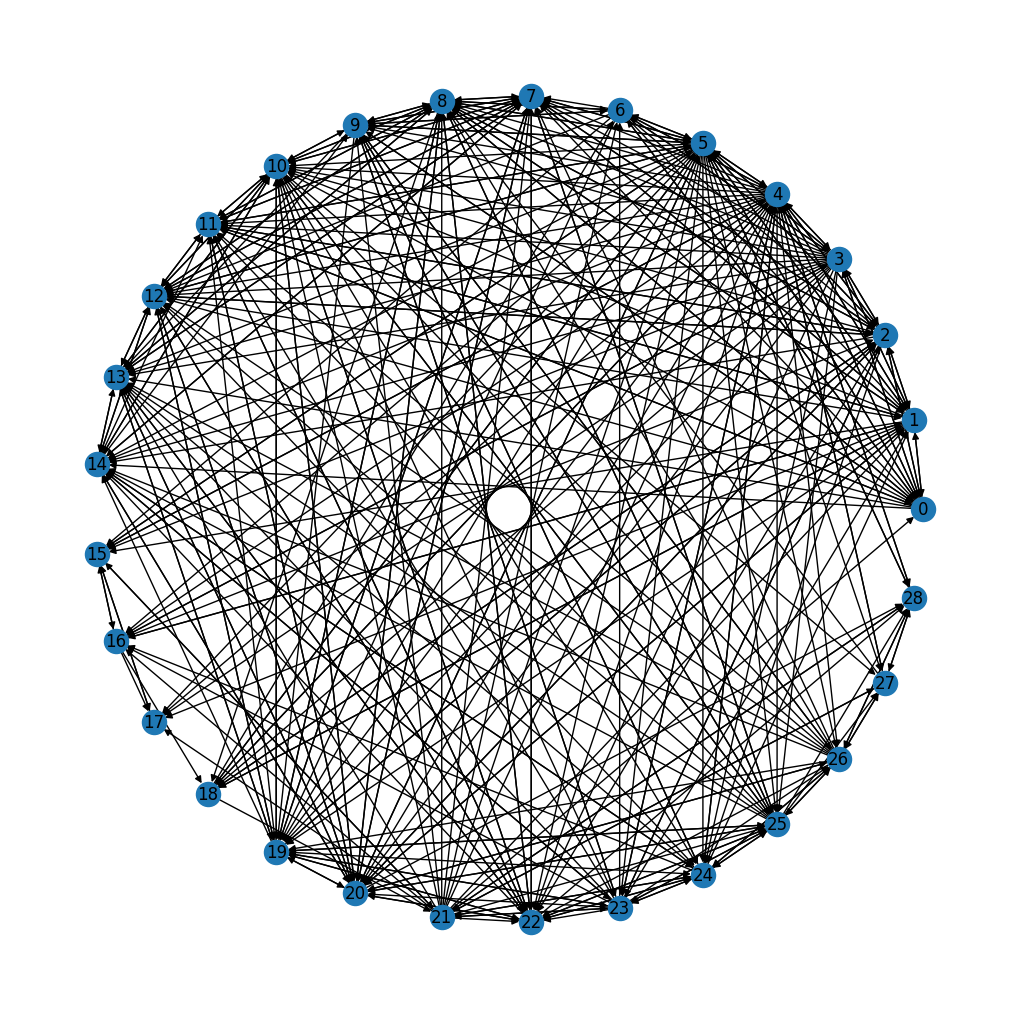

In [231]:
import networkx as nx
import matplotlib.pyplot as plt
  
G = nx.DiGraph()
G.add_weighted_edges_from(w_edges)
  
plt.figure(figsize =(10, 10))
nx.draw_circular(G, with_labels = True)
hubs, authorities = nx.hits(G, max_iter = 100, normalized = True, tol=1e-9)

In [232]:
import operator

# I sort the results and get the top tens only
sorted_hubs = dict(sorted(hubs.items(), key=operator.itemgetter(1), reverse=True)[:10])
sorted_aut = dict(sorted(authorities.items(), key=operator.itemgetter(1), reverse=True)[:10])

hubs_df = pd.DataFrame(sorted_hubs.keys(), columns=['node_id'])
aut_df = pd.DataFrame(sorted_aut.keys(), columns=['node_id'])

display("Top 10 hub Scores: ", hubs_df)
display("Top 10 authority Scores: ", aut_df)

'Top 10 hub Scores: '

,node_id
0,4
1,5
2,3
3,2
4,21
5,8
6,25
7,26
8,20
9,7


'Top 10 authority Scores: '

,node_id
0,7
1,8
2,10
3,13
4,11
5,22
6,19
7,20
8,12
9,14


Now I check if the results with NteworkX and the ierative algorithms are the same

In [233]:
pd.concat([rank_hubs, hubs_df], keys=['Iterative HITS hubs', 'Network X HITS hubs'], axis=1)

,Iterative HITS hubs,Network X HITS hubs
,node_id,node_id
0,4,4
1,5,5
2,3,3
3,2,2
4,21,21
5,8,8
6,25,25
7,26,26
8,20,20


In [234]:
pd.concat([rank_aut, aut_df], keys=['Iterative HITS authorities', 'Network X HITS authorities'], axis=1)

,Iterative HITS authorities,Network X HITS authorities
,node_id,node_id
0,7,7
1,8,8
2,10,10
3,13,13
4,11,11
5,22,22
6,19,19
7,20,20
8,12,12


### Bigger dataset
I try to work on a bigger dataset: movielens, which has users and their ratings for the movies they have seen.

#### Iterative Algorithm

In [235]:
hits = SparseHITS()
hits.load_graph_dataset('./data/movielens-100k', is_undirected=False)
print("The number n of nodes: {}".format(hits.n))
print("The number m of edges: {}".format(hits.m))

The number n of nodes: 2625
The number m of edges: 100000


In [236]:
hits = SparseHITS()
hits.load_graph_dataset('./data/movielens-100k', is_undirected=False)
h, a, _, _, n_iterations = hits.iterate_HITS(epsilon=1e-9, max_iters=100)

print("{} iterations were necessary.".format(n_iterations))

rank_hubs = rank_nodes(h, 10)
rank_aut = rank_nodes(a, 10)

print("Top-10 rankings based on the hub score vector:")
display(rank_hubs)

print("Top-10 rankings based on the authority score vector:")
display(rank_aut)

12 iterations were necessary.
Top-10 rankings based on the hub score vector:


,node_id
0,449
1,415
2,275
3,12
4,58
5,302
6,6
7,307
8,473
9,428


Top-10 rankings based on the authority score vector:


,node_id
0,992
1,1116
2,1123
3,1042
4,1040
5,1114
6,998
7,1069
8,943
9,1146


#### Network X

In [237]:
with open('edges_movies.csv') as f:
    data=[tuple(line) for line in csv.reader(f)]

In [238]:
def create_w_edges(data):
    my_edges = [(int(i[0]), int(i[1]), int(i[2])) for i in data]
    return my_edges

w_edges = create_w_edges(data)

In [239]:
G = nx.DiGraph()
G.add_weighted_edges_from(w_edges)

# I comment the plot since the plot is so big (it takes too much time and is unreadable)
#plt.figure(figsize =(10, 10))
#nx.draw_circular(G, with_labels = True)
hubs, authorities = nx.hits(G, max_iter = 100, normalized = True, tol=1e-9)

In [240]:
sorted_hubs = dict(sorted(hubs.items(), key=operator.itemgetter(1), reverse=True)[:10])
sorted_aut = dict(sorted(authorities.items(), key=operator.itemgetter(1), reverse=True)[:10])

hubs_df = pd.DataFrame(sorted_hubs.keys(), columns=['node_id'])
aut_df = pd.DataFrame(sorted_aut.keys(), columns=['node_id'])

display("Top 10 hub Scores: ", hubs_df)
display("Top 10 authority Scores: ", aut_df)

'Top 10 hub Scores: '

,node_id
0,449
1,415
2,275
3,12
4,58
5,302
6,6
7,307
8,473
9,428


'Top 10 authority Scores: '

,node_id
0,992
1,1116
2,1123
3,1042
4,1040
5,1114
6,998
7,1069
8,943
9,1146


In [241]:
pd.concat([rank_hubs, hubs_df], keys=['Iterative HITS hubs', 'Network X HITS hubs'], axis=1)

,Iterative HITS hubs,Network X HITS hubs
,node_id,node_id
0,449,449
1,415,415
2,275,275
3,12,12
4,58,58
5,302,302
6,6,6
7,307,307
8,473,473


In [242]:
pd.concat([rank_aut, aut_df], keys=['Iterative HITS authorities', 'Network X HITS authorities'], axis=1)

,Iterative HITS authorities,Network X HITS authorities
,node_id,node_id
0,992,992
1,1116,1116
2,1123,1123
3,1042,1042
4,1040,1040
5,1114,1114
6,998,998
7,1069,1069
8,943,943


### Step 3. Validate the HITS implementation

We will validate the implementation of HITS, by checking if the residuals of the iterative algorithm monotonically decrease and comparing between the exact and iterative solutions of HITS. 

#### Step 3-1. Check if the residuals of the iterative algorithm monotonically decrease

In [243]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13}) # set the font-size in the figure

# A function to draw my plot
def plot_residuals(residuals, title):
    plt.semilogy(residuals, marker='o', markersize=5)
    plt.title(title)
    plt.ylim(bottom=1e-10, top=1e1)
    plt.ylabel('Residual')
    plt.xlabel('# of iterations')
    plt.grid(True)
    plt.show()

Let's check the plot for the hub residuals first. 

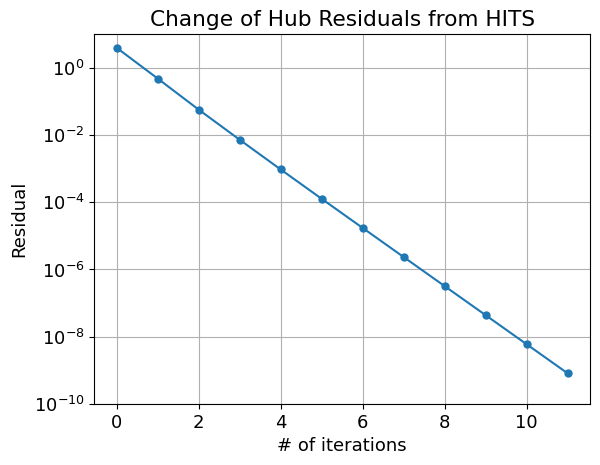

In [244]:
hits = SparseHITS()
hits.load_graph_dataset('./data/small', is_undirected=False)
h, a, h_residuals, a_residuals, n_iterations = hits.iterate_HITS(epsilon=1e-9, max_iters=100)

plot_residuals(h_residuals, 'Change of Hub Residuals from HITS')

Next, the following will plot the authority residuals. 

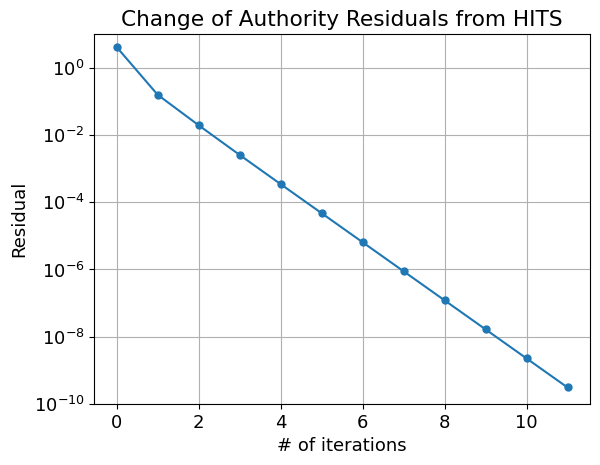

In [245]:
plot_residuals(a_residuals, 'Change of Authority Residuals from HITS')

The residuals monotonically decrease as the number of iteration increases, so the algorithm is working.

### Sensitivity analysis

In [246]:
# Define the function again, this time with no default values for epsilon and max_iters
class SparseHITS(SparseHITS):
    def iterate_HITS(self, epsilon, max_iters): 
        old_h = np.ones(self.n)/self.n
        old_a = np.ones(self.n)/self.n
        h_residuals = []
        a_residuals = []
        
        for t in range(max_iters):
            h = self.A.dot(old_a)
            a = self.AT.dot(h)
                        
            h = h / np.linalg.norm(h, 2)
            a = a / np.linalg.norm(a, 2)
            
            h_residual = np.linalg.norm(h - old_h, 1)
            a_residual = np.linalg.norm(a - old_a, 1)
            h_residuals.append(h_residual)
            a_residuals.append(a_residual)
            old_h = h
            old_a = a
            
            if h_residual < epsilon and a_residual < epsilon:
                break
        return h, a, h_residuals, a_residuals, t

In [247]:
# Some possible values for epsilon and max_iters
error = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
iterations = [25, 50, 75, 100, 150, 200, 350, 500, 750, 1000]

I check if for differnt values of epsilon and maxIters the results of the algorithm change

In [251]:
import itertools

perm = list(itertools.product(error, iterations))

hits = SparseHITS()
hits.load_graph_dataset('./data/small', is_undirected=False)
h_orig, a_orig, _, _, n_iter = hits.iterate_HITS(epsilon=1e-9, max_iters= 100)

rank_hubs_orig = rank_nodes(h_orig, 10)
rank_aut_orig = rank_nodes(a_orig, 10)

# I iterate the HITS algorithm for all the possible combinations of epsilon and max_iters and I check if the results are the same as the original ones
for j in range(len(perm)):
    h, a, _, _, n_iterations = hits.iterate_HITS(epsilon = perm[j][0], max_iters = perm[j][1])
    rank_hubs = rank_nodes(h, 10)
    rank_aut = rank_nodes(a, 10)
    
    if (not rank_hubs_orig.equals(rank_hubs)) or (not rank_aut_orig.equals(rank_aut)):
        print("{} iterations were necessary.".format(n_iterations))

        print("Top-10 rankings based on the hub score vector:")
        display(rank_hubs)

        print("Top-10 rankings based on the authority score vector:")
        display(rank_aut)

#### Salsa

The authority scores are given by

$\mathbf{a_i} = \frac{{N_j}}{{N}}\frac{{|B(i)|}}{{|B|}}$

where j is thecomponent that contains node i, Nj its number of nodes, and Bj the set of (backward) links in component it.

In [249]:
hits.load_graph_dataset('./data/small', is_undirected=False)
adjacency_matrix = hits.A

In [250]:
def calculate_authority_weight(adj_matrix, node):
    num_nodes = adj_matrix.shape[0] #shape[0] returns the number of rows in the matrix, which corresponds to the number of nodes
    components = find_components(adj_matrix)
    component = find_component(node, components)
    
    if len(component) == 1: # then the node is not connected to any other nodes in the graph
        return 1.0
    
    num_nodes_component = len(component)
    num_backward_links_node = count_backward_links_node(adj_matrix, node)
    num_backward_links_component = count_backward_links_component(adj_matrix, component)
    
    if num_backward_links_component == 0 or num_backward_links_node == 0:
        return 0.0
    
    # calculate the authority weight as the formula specified before
    return (num_nodes_component / num_nodes) * (num_backward_links_node / num_backward_links_component)

# find all the connected components in the graph
def find_components(adj_matrix):
    num_nodes = adj_matrix.shape[0]
    visited = np.zeros(num_nodes, dtype=bool) # keeps track of whether a node has been visited or not
    components = []
    
    # for each node in the graph
    for node in range(num_nodes):
        if not visited[node]:
            component = set() # empty set for the nodes in the connected component
            explore_component(adj_matrix, node, component, visited)
            components.append(component)
    
    return components

# explore the connected component that contains the given node
def explore_component(adj_matrix, node, component, visited):
    component.add(node)
    visited[node] = True

    # get the indices of the neighbors of the current node from the adjacency matrix    
    neighbors = adj_matrix.indices[adj_matrix.indptr[node]:adj_matrix.indptr[node+1]]
    for neighbor in neighbors:
        if not visited[neighbor]:
            explore_component(adj_matrix, neighbor, component, visited)

# find the connected component that contains the given node
def find_component(node, components):
    for component in components:
        if node in component:
            return component
    
    return set()

# count the number of backward links of the node
def count_backward_links_node(adj_matrix, node):
    neighbors = adj_matrix.indices[adj_matrix.indptr[node]:adj_matrix.indptr[node+1]]
    count = sum(1 for neighbor in neighbors if not adj_matrix[neighbor, node])
    
    return count

# calculate the total number of backward links within the connected component
def count_backward_links_component(adj_matrix, component):
    # track the number of backward links in the component
    count = 0
    
    for node in component:
        count += count_backward_links_node(adj_matrix, node)
    
    return count

def find_top_nodes_by_authority(adj_matrix, num_nodes=10):
    node_weights = {}
    for node in range(adj_matrix.shape[0]):
        weight = calculate_authority_weight(adj_matrix, node)
        node_weights[node] = weight
    
    top_nodes = sorted(node_weights, key=node_weights.get, reverse=True)[:num_nodes]
    return top_nodes

top_nodes = find_top_nodes_by_authority(adjacency_matrix)
print("Top 10 nodes by authority weight:")
for node in top_nodes:
    print(f"Node {node}")


Top 10 nodes by authority weight:
Node 3
Node 4
Node 21
Node 5
Node 26
Node 23
Node 6
Node 25
Node 0
Node 1
